In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline
import statsmodels.api as sm
from datetime import timedelta,datetime

# read train, test data, and state table

In [2]:
# read training data and transition matrix
df=pd.read_csv("SH_SDS_data_4.csv",index_col=0)
prob=pd.read_csv("SH_SDS_transition_matrix.csv",index_col=0)
df.index = pd.to_datetime(df.index,utc=True)

In [4]:
# rebuild the index of transition matrix
rows=[]
for price_relation_d in range(6):
    for s1_imb_d in range(3):
        for s2_imb_d in range(3):
            s1_imb_d, s2_imb_d, price_relation_d = str(s1_imb_d),str(s2_imb_d),str(price_relation_d)
            rows.append(price_relation_d+s1_imb_d+s2_imb_d)
prob.index=rows

In [6]:
markov_adj=pd.read_csv('Markov_exp_move.csv',index_col=0)
markov_adj.index=rows

In [8]:
state_table=markov_adj
df.current_state=df.current_state.astype('str')
for i in range(len(df)):
    state=df.current_state.iloc[i]
    if len(state)<3:
        df.current_state.iloc[i]='0'+state
state_table=state_table.assign(freq=state_table.index.map(df.current_state.value_counts())).fillna(0)

C:\Users\Anne Shen\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
# read testing data and transition matrix
df_test=pd.read_csv("SH_SDS_data_Dec2.csv",index_col=0)
df_test.drop(index=[0],inplace=True)  # remove the first row because the time interval btw row 0 and 1 is not 10 seconds
df_test.reset_index(drop=True,inplace=True)

# in-sample parameters calculation and test data preparation

In [11]:
def calculate_train_parameters(df, res_num, imb1_num, imb2_num):
    # calculate in-sample beta, constant, and symmetrize data and cut states
    X = sm.add_constant(df.mid2)
    res = sm.OLS(df.mid1, X).fit()
    constant=res.params[0]
    slope=res.params[1]
    
    df['residual_bucket'], res_bins = pd.cut(df['residuals'], res_num, labels=False, retbins=True)
    df['imb1_bucket'], imb1_bins = pd.cut(df.imb1, imb1_num, labels=False, retbins=True)
    df['imb2_bucket'], imb2_bins = pd.cut(df.imb2, imb2_num, labels=False, retbins=True)
    
    return slope, constant, res_bins, imb1_bins, imb2_bins

In [12]:
res_num=6
imb1_num=3
imb2_num=3
slope, constant, res_bins, imb1_bins, imb2_bins=calculate_train_parameters(df, res_num, imb1_num, imb2_num)

In [14]:
def change_bins_end_boundaries(bins):
    # change the left and right most boundaries in order to use the bins on test data
    bins[0]=-10
    bins[-1]=10

change_bins_end_boundaries(res_bins)
change_bins_end_boundaries(imb1_bins)
change_bins_end_boundaries(imb2_bins)

In [15]:
def prep_test_data(df, slope, constant, res_bins, imb1_bins, imb2_bins):
    # symmetrize test data, cut states based on the training parameters and construct states
    df['mid1']=(df.bid1+df.ask1)/2
    df['mid2']=(df.bid2+df.ask2)/2
    
    predicted_Y=constant+slope*df.mid2
    df['residuals']=df.mid1-predicted_Y
    
    df_flip=df.copy()
    df_flip.columns=['time', 'ask1', 'ask_size1', 'bid1', 'bid_size1', 'ask2', 'ask_size2', 'bid2', 'bid_size2',
                     'mid1','mid2','residuals']
    df_flip[['ask1', 'bid1', 'ask2', 'bid2','residuals']]=-df_flip[['ask1', 'bid1', 'ask2', 'bid2','residuals']]

    change1=df.bid1[len(df)-1]-df_flip.bid1[0]-0.01
    change2=df.bid2[len(df)-1]-df_flip.bid2[0]-0.01

    df_flip[['ask1', 'bid1']]=df_flip[['ask1', 'bid1']]+change1
    df_flip[['ask2', 'bid2']]=df_flip[['ask2', 'bid2']]+change2
    
    df_flip['mid1']=(df_flip.bid1+df_flip.ask1)/2
    df_flip['mid2']=(df_flip.bid2+df_flip.ask2)/2
    predicted_Y_flip=constant+slope*df_flip.mid2

    df_flip.time=pd.to_datetime(df_flip.time)
    df_flip.time+=timedelta(hours=6)
    
    df.set_index("time",inplace=True)
    df.index = pd.to_datetime(df.index,utc=True)
    df['imb1']=df.bid_size1/(df.bid_size1+df.ask_size1)
    df['imb2']=df.bid_size2/(df.bid_size2+df.ask_size2)
    df2=df[['residuals','mid1','mid2','imb1','imb2']]
    df2.index = df.index.shift(-10,freq='S')
    df2.columns=['residual_later','mid1_later','mid2_later','imb1_later','imb2_later']
    df = pd.merge_asof(df, df2, left_index=True, right_index=True, direction='forward')
    df['pnl'] = df.residual_later-df.residuals  # forward pnl
    df['mid1_diff'] = df.mid1_later-df.mid1
    df['mid2_diff'] = df.mid2_later-df.mid2
    df.dropna(inplace=True)
    
    df_flip.set_index("time",inplace=True)
    df_flip.index = pd.to_datetime(df_flip.index,utc=True)
    df_flip['imb1']=df_flip.bid_size1/(df_flip.bid_size1+df_flip.ask_size1)
    df_flip['imb2']=df_flip.bid_size2/(df_flip.bid_size2+df_flip.ask_size2)
    df2_flip=df_flip[['residuals','mid1','mid2','imb1','imb2']]
    df2_flip.index = df_flip.index.shift(-10,freq='S')# - timedelta(minutes=5)  # data from 5 minutes later
    df2_flip.columns=['residual_later','mid1_later','mid2_later','imb1_later','imb2_later']
    df_flip = pd.merge_asof(df_flip, df2_flip, left_index=True, right_index=True, direction='forward')
    df_flip['pnl'] = df_flip.residual_later-df_flip.residuals  # forward pnl
    df_flip['mid1_diff'] = df_flip.mid1_later-df_flip.mid1
    df_flip['mid2_diff'] = df_flip.mid2_later-df_flip.mid2
    df_flip.dropna(inplace=True)
    
    df=pd.concat([df,df_flip])

    df.index = pd.to_datetime(df.index,utc=True)
    
    df['residual_bucket'] = pd.cut(df['residuals'], res_bins, labels=False)
    
    df['imb1']=df.bid_size1/(df.bid_size1+df.ask_size1)
    df['imb2']=df.bid_size2/(df.bid_size2+df.ask_size2)
    df['imb1_bucket'] = pd.cut(df.imb1, imb1_bins, labels=False)
    df['imb2_bucket'] = pd.cut(df.imb2, imb2_bins, labels=False)
    
    df['dM1']=1*(df.mid1_diff>0)
    df.dM1-=1*(df.mid1_diff<0)
    df['dM2']=1*(df.mid2_diff>0)
    df.dM2-=1*(df.mid2_diff<0)

    df['residual_bucket_later'] = pd.cut(df['residual_later'], res_bins, labels=False)
    df['imb1_bucket_later'] = pd.cut(df['imb1_later'], imb1_bins, labels=False)
    df['imb2_bucket_later'] = pd.cut(df['imb2_later'], imb2_bins, labels=False)
    
    df['current_state']=df["residual_bucket"].astype(str) + df["imb1_bucket"].astype(str) + df["imb2_bucket"].astype(str)
    df['later_state']=df["residual_bucket_later"].astype(str)+df["imb1_bucket_later"].astype(str)+df["imb2_bucket_later"].astype(str)+df.dM1.astype(str)+df.dM2.astype(str)
    
    x=df.dM1.astype(str)+df.dM2.astype(str)
    df.drop(index=df.index[np.where((x=='-1-1')|(x=='11'))],inplace=True)
    return df

In [16]:
df_test=prep_test_data(df_test, slope, constant, res_bins, imb1_bins, imb2_bins)

In [17]:
df_test.current_state=df_test.current_state.astype('str')
for i in range(len(df_test)):
    state=df_test.current_state.iloc[i]
    if len(state)<3:
        df_test.current_state.iloc[i]='0'+state

# Random algo
At the beginning of each 5 minutes, buy or sell \\$1000 SH or \\$500 SDS

In [18]:
class buyer:
    
    def __init__(self, cash,pnl, inventory1,inventory2,price1,price2):
        self.cash = cash
        self.inventory1 = inventory1
        self.inventory2 = inventory2
        self.price1=price1
        self.price2=price2
        self.pnl=pnl
        self.pnl_list=[]
        self.inventory1_list=[]
        self.inventory2_list=[]
        self.price1_list=[]
        self.price2_list=[]
        self.tick = 0.01
        
    def get_pnl(self):
        return self.pnl_list
    
    def get_inventory(self):
        return self.inventory1_list, self.inventory2_list
        
    def trade_SH(self,price1,price2):
        self.price1=price1
        self.price2=price2
        self.price1_list.append(self.price1)
        self.inventory1=self.inventory1+1000/(self.price1+self.tick/2)  #buy SH
        self.cash=self.cash-1000
        
    def trade_SDS(self,price1,price2):
        self.price1=price1
        self.price2=price2
        self.price2_list.append(self.price2)
        self.inventory2=self.inventory2+500/(self.price2+self.tick/2)  #buy SDS
        self.cash=self.cash-500
        
    def check_buy_SH_or_SDS(self,state,inventory1,inventory2,price1,price2):
        if state=='SDS':
            self.trade_SDS(price1,price2)
            self.pnl=self.cash+self.inventory1*(price1)+self.inventory2*(price2)
        elif state=='SH':
            self.trade_SH(price1,price2)
            self.pnl=self.cash+self.inventory1*(price1)+self.inventory2*(price2)
        else:
            self.inventory1=inventory1
            self.inventory2=inventory2
            
        self.pnl_list.append(self.pnl)
        self.inventory1_list.append(self.inventory1)
        self.inventory2_list.append(self.inventory2)
        return self.inventory1, self.inventory2, self.price1_list, self.price2_list

In [19]:
class seller:
    
    def __init__(self,cash,pnl,inventory1,inventory2,price1,price2):
        self.cash = cash
        self.inventory1 = inventory1
        self.inventory2 = inventory2
        self.price1=price1
        self.price2=price2
        self.pnl=pnl
        self.pnl_list=[]
        self.inventory1_list=[]
        self.inventory2_list=[]
        self.price1_list=[]
        self.price2_list=[]
        self.tick = 0.01
        
    def get_pnl(self):
        return self.pnl_list
    
    def get_inventory(self):
        return self.inventory1_list, self.inventory2_list
        
    def trade_SH(self,price1,price2):
        self.price1=price1
        self.price2=price2
        self.price1_list.append(self.price1)
        self.inventory1=self.inventory1-1000/(self.price1-self.tick/2)  #sell SH
        self.cash=self.cash+1000
        
    def trade_SDS(self,price1,price2):
        self.price1=price1
        self.price2=price2
        self.price2_list.append(self.price2)
        self.inventory2=self.inventory2-500/(self.price2-self.tick/2)  #sell SDS
        self.cash=self.cash+500
        
    def check_sell_SH_or_SDS(self,state,inventory1,inventory2,price1,price2):
        if state=='SDS':
            self.trade_SDS(price1,price2)
#             self.cost+=self.inventory2*(price2+self.tick/2)
            self.pnl=self.cash+self.inventory1*(price1)+self.inventory2*(price2)
        elif state=='SH':
            self.trade_SH(price1,price2)
#             self.cost+=self.inventory1*(price1+self.tick/2)
            self.pnl=self.cash+self.inventory1*(price1)+self.inventory2*(price2)
        else:
            self.inventory1=inventory1
            self.inventory2=inventory2
        
        self.pnl_list.append(self.pnl)
        self.inventory1_list.append(self.inventory1)
        self.inventory2_list.append(self.inventory2)
        
        return self.inventory1, self.inventory2, self.price1_list, self.price2_list

In [20]:
# random algo
def random_algo(df,buy_or_sell='s'):
    # buy_or_sell: 'b' -- buy, else sell
    tick = 0.01
    cash=0
    pnl=0
    inventory1=0
    inventory2=0
    
    df_random=df[~df.index.duplicated(keep='first')].resample('5T').first()
    np.random.seed(123)
    df_random['random_which_asset']=np.random.choice(['SH','SDS'],size=len(df_random))
    
    if buy_or_sell=='b':
        t1=buyer(cash,pnl,inventory1,inventory2,df_random.mid1[0],df_random.mid2[0])
        for i in range(len(df_random)):
            inventory1, inventory2,price1_list,price2_list=t1.check_buy_SH_or_SDS(df_random.random_which_asset[i],inventory1,inventory2,df_random.mid1[i],df_random.mid2[i])
        print('Random algo buys',inventory1,'shares of SH and',inventory2,'shares of SDS for a total used cash $', -t1.cash, 'and total pnl $', t1.pnl)

    else:
        t1=seller(cash,pnl,inventory1,inventory2,df_random.mid1[0],df_random.mid2[0])
        for i in range(len(df_random)):
            inventory1, inventory2,price1_list,price2_list=t1.check_sell_SH_or_SDS(df_random.random_which_asset[i],inventory1,inventory2,df_random.mid1[i],df_random.mid2[i])
        print('Random algo sells',-inventory1,'shares of SH and',-inventory2,'shares of SDS for a total used cash $', t1.cash, 'and total pnl $', t1.pnl)

    # average trade price for SH
    price1=np.mean(price1_list)
    # average trade price for SDS
    price2=np.mean(price2_list)
    print('Average trade price for SH is $',price1)
    print('Average trade price for SDS is $',price2)
    print('Sum of Avg_price * inventory for SH+SDS is $',price1*inventory1+price2*inventory2)
    
    results.append([buy_or_sell,'1. random algo',price1,inventory1,price2,inventory2,t1.pnl])
    
    plt.plot(t1.get_pnl())
    
    return df_random

# Weighted-mid-vs-mid Algo
At the beginning of each 5 minutes, buy or sell \\$1000 SH or \\$500 SDS based on weighted mid minus mid

In [21]:
# Average shares of each asset at one execution
SH_shares=1000/np.mean(df.mid1)
SDS_shares=500/np.mean(df.mid2)

In [22]:
# weighted-mid algo
def weighted_mid_algo(df,buy_or_sell='s'):
    # buy_or_sell: 'b' -- buy, else sell
    tick = 0.01
    cash=0
    pnl=0
    inventory1=0
    inventory2=0
    
    df_weighted=df[~df.index.duplicated(keep='first')].resample('5T').first()
    df_weighted['weighted_mid1']=(df_weighted.ask1 * df_weighted.bid_size1 + df_weighted.bid1 * df_weighted.ask_size1) / (df_weighted.ask_size1 + df_weighted.bid_size1)
    df_weighted['weighted_mid2']=(df_weighted.ask2 * df_weighted.bid_size2 + df_weighted.bid2 * df_weighted.ask_size2) / (df_weighted.ask_size2 + df_weighted.bid_size2)
    
    if buy_or_sell == 'b':
        df_weighted.loc[SH_shares*(df_weighted.weighted_mid1-df_weighted.mid1) >= SDS_shares*(df_weighted.weighted_mid2-df_weighted.mid2), 'weighted_which_asset']='SH'
        df_weighted.loc[SH_shares*(df_weighted.weighted_mid1-df_weighted.mid1) < SDS_shares*(df_weighted.weighted_mid2-df_weighted.mid2), 'weighted_which_asset']='SDS'
    else:
        df_weighted.loc[SH_shares*(df_weighted.weighted_mid1-df_weighted.mid1) >= SDS_shares*(df_weighted.weighted_mid2-df_weighted.mid2), 'weighted_which_asset']='SDS'
        df_weighted.loc[SH_shares*(df_weighted.weighted_mid1-df_weighted.mid1) < SDS_shares*(df_weighted.weighted_mid2-df_weighted.mid2), 'weighted_which_asset']='SH'
    
    if buy_or_sell=='b':
        t1=buyer(cash,pnl,inventory1,inventory2,df_weighted.mid1[0],df_weighted.mid2[0])
        for i in range(len(df_weighted)):
            inventory1, inventory2,price1_list,price2_list=t1.check_buy_SH_or_SDS(df_weighted.weighted_which_asset[i],inventory1,inventory2,df_weighted.mid1[i],df_weighted.mid2[i])
        print('Weighted_mid algo buys',inventory1,'shares of SH and',inventory2,'shares of SDS for a total used cash $', -t1.cash, 'and total pnl $', t1.pnl)

    else:
        t1=seller(cash,pnl,inventory1,inventory2,df_weighted.mid1[0],df_weighted.mid2[0])
        for i in range(len(df_weighted)):
            inventory1, inventory2,price1_list,price2_list=t1.check_sell_SH_or_SDS(df_weighted.weighted_which_asset[i],inventory1,inventory2,df_weighted.mid1[i],df_weighted.mid2[i])
        print('Weighted_mid algo sells',-inventory1,'shares of SH and',-inventory2,'shares of SDS for a total used cash $', t1.cash, 'and total pnl $', t1.pnl)

    # average trade price for SH
    price1=np.mean(price1_list)
    # average trade price for SDS
    price2=np.mean(price2_list)
    print('Average trade price for SH is $',price1)
    print('Average trade price for SDS is $',price2)
    print('Sum of Avg_price * inventory for SH+SDS is $',price1*inventory1+price2*inventory2)
    
    results.append([buy_or_sell,'2. weighted mid algo',price1,inventory1,price2,inventory2,t1.pnl])
    
    plt.plot(t1.get_pnl())
    
    return df_weighted

# Execute at the beginnning based on micro price
At the beginning of each 5 minutes, buy or sell \$1000 SH or \\$500 SDS based on micro price adjustment

In [23]:
# trade at the beginning of every 5 minute, based on micro price
def micro_algo(df,state_table,buy_or_sell='s'):
    # buy_or_sell: 'b' -- buy, else sell
    tick = 0.01
    cash=0
    pnl=0
    inventory1=0
    inventory2=0
#     x=state_table.rename_axis('current_state').reset_index()
#     df=df.join(x,on='current_state')
    
    df_micro=df.assign(price1_change_5step=df.current_state.map(state_table.price1_change_5step),price2_change_5step=df.current_state.map(state_table.price2_change_5step))
    df_micro=df_micro[~df.index.duplicated(keep='first')].resample('5T').first()
    
    if buy_or_sell == 'b':
        df_micro.loc[SH_shares*(df_micro.price1_change_5step) >= SDS_shares*(df_micro.price2_change_5step), 'micro_which_asset']='SH'
        df_micro.loc[SH_shares*(df_micro.price1_change_5step) < SDS_shares*(df_micro.price2_change_5step), 'micro_which_asset']='SDS'
    else:
        df_micro.loc[SH_shares*(df_micro.price1_change_5step) >= SDS_shares*(df_micro.price2_change_5step), 'micro_which_asset']='SDS'
        df_micro.loc[SH_shares*(df_micro.price1_change_5step) < SDS_shares*(df_micro.price2_change_5step), 'micro_which_asset']='SH'
        
        
    if buy_or_sell=='b':
        t1=buyer(cash,pnl,inventory1,inventory2,df_micro.mid1[0],df_micro.mid2[0])
        for i in range(len(df_micro)):
            inventory1, inventory2,price1_list,price2_list=t1.check_buy_SH_or_SDS(df_micro.micro_which_asset[i],inventory1,inventory2,df_micro.mid1[i],df_micro.mid2[i])
        print('Micro algo buys',inventory1,'shares of SH and',inventory2,'shares of SDS for a total used cash $', -t1.cash, 'and total pnl $', t1.pnl)

    else:
        t1=seller(cash,pnl,inventory1,inventory2,df_micro.mid1[0],df_micro.mid2[0])
        for i in range(len(df_micro)):
            inventory1, inventory2,price1_list,price2_list=t1.check_sell_SH_or_SDS(df_micro.micro_which_asset[i],inventory1,inventory2,df_micro.mid1[i],df_micro.mid2[i])
        print('Micro algo sells',-inventory1,'shares of SH and',-inventory2,'shares of SDS for a total used cash $', t1.cash, 'and total pnl $', t1.pnl)

    
    # average trade price for SH
    price1=np.mean(price1_list)
    # average trade price for SDS
    price2=np.mean(price2_list)
    print('Average trade price for SH is $',price1)
    print('Average trade price for SDS is $',price2)
    print('Sum of Avg_price * inventory for SH+SDS is $',price1*inventory1+price2*inventory2)
    
    results.append([buy_or_sell,'3. micro algo',price1,inventory1,price2,inventory2,t1.pnl])
    
    plt.plot(t1.get_pnl())
    
    return df_micro

# Amrican Sniper Algo using abs diff with constant threshold
Inside each 5 minutes, buy or sell \\$1000 SH or \\$500 SDS based on a threshold

In [24]:
# cut the absolute difference btw two adjustments into 30 buckets
state_table['30cuts_allocation_absDiff']=pd.cut((SH_shares*state_table.price1_change_5step-SDS_shares*state_table.price2_change_5step).abs(),bins=30,labels=False)

In [25]:
# American snipper algo using absolute difference of adjustments with 
def american_sniper_algo_absDiff_constant(df,state_table,threshold,traded_limit,buy_or_sell='s'):
    # buy_or_sell: 'b' -- buy, else sell
    # threshold: an integer or a list of thresholds
    # traded_limit: length of the 5-min-resampled data frame in previous algos
    tick = 0.01
    cash=0
    pnl=0
    inventory1=0
    inventory2=0
    num_traded=0
    traded_time=[]
    
    df['which_asset']='0'
    df['theshold_bucket']=threshold # or use [29-i%30 for i in range(len(df))] as a decreasing-over-time threshold
    df=df.join(state_table,'current_state')
    traded=False
    
    index_5_min=df[~df.index.duplicated(keep='first')].resample("5T").first().index
    df_every_5_min=pd.DataFrame([1]*len(index_5_min),index=index_5_min,columns=['5_min_start'])
    df['real_time']=df.index
    trade_period=pd.merge_asof(df_every_5_min, df.real_time.sort_index(), left_index=True, right_index=True, direction="forward")
    df2=df[~df.index.duplicated(keep='first')].merge(trade_period.set_index('real_time'),'left',left_index=True,right_index=True).fillna(0)
    
    
    if buy_or_sell=='b':
        if (df2.iloc[0]['theshold_bucket']<=df2.iloc[0]['30cuts_allocation_absDiff']) & (traded==False):
            if SH_shares*df2.iloc[0].price1_change_5step >= SDS_shares*df2.iloc[0].price2_change_5step:
                df2.which_asset.iloc[0]='SH'
            else:
                df2.which_asset.iloc[0]='SDS'
            traded=True
            num_traded+=1
            traded_time.append('early')
        for i in range(1,len(df2)):
            if (df2['5_min_start'].iloc[i]!=1) & (df2.iloc[i-1]['theshold_bucket']<=df2.iloc[i-1]['30cuts_allocation_absDiff']) & (traded==False):
                if SH_shares*df2.iloc[i-1].price1_change_5step >= SDS_shares*df2.iloc[i-1].price2_change_5step:
                    df2.which_asset.iloc[i-1]='SH'
                else:
                    df2.which_asset.iloc[i-1]='SDS'
                traded=True
                num_traded+=1
                traded_time.append('early')
                
            if df2['5_min_start'].iloc[i]==1:
                if traded==False:
                    if SH_shares*df2.iloc[i-1].price1_change_5step >= SDS_shares*df2.iloc[i-1].price2_change_5step:
                        df2.which_asset.iloc[i-1]='SH'
                    else:
                        df2.which_asset.iloc[i-1]='SDS'
                    num_traded+=1
                    traded_time.append('end_of_5_min')
                else:
                    traded=False
                    
            if num_traded==traded_limit:
                break
        
        df_trade=df2[df2.which_asset!='0']
        t1=buyer(cash,pnl,inventory1,inventory2,df_trade.mid1[0],df_trade.mid2[0])
        for i in range(len(df_trade)):
            inventory1, inventory2,price1_list,price2_list=t1.check_buy_SH_or_SDS(df_trade.which_asset[i],inventory1,inventory2,df_trade.mid1[i],df_trade.mid2[i])
        print('American snipper algo (abs diff) buys',inventory1,'shares of SH and',inventory2,
              'shares of SDS for a total used cash $', -t1.cash, 'and total pnl $', t1.pnl)

    else:
        if (df2.iloc[0]['theshold_bucket']<=df2.iloc[0]['30cuts_allocation_absDiff']) & (traded==False):
            if SH_shares*df2.iloc[0].price1_change_5step <= SDS_shares*df2.iloc[0].price2_change_5step:
                df2.which_asset.iloc[0]='SH'
            else:
                df2.which_asset.iloc[0]='SDS'
            traded=True
            num_traded+=1
            traded_time.append('early')
        for i in range(1,len(df2)-1):
            if (df2['5_min_start'].iloc[i]!=1) & (df2.iloc[i-1]['theshold_bucket']<=df2.iloc[i-1]['30cuts_allocation_absDiff']) & (traded==False):
                if SH_shares*df2.iloc[i-1].price1_change_5step <= SDS_shares*df2.iloc[i-1].price2_change_5step:
                    df2.which_asset.iloc[i-1]='SH'
                else:
                    df2.which_asset.iloc[i-1]='SDS'
                traded=True
                num_traded+=1
                traded_time.append('early')
                
            if df2['5_min_start'].iloc[i]==1:
                if traded==False:
                    if SH_shares*df2.iloc[i-1].price1_change_5step <= SDS_shares*df2.iloc[i-1].price2_change_5step:
                        df2.which_asset.iloc[i-1]='SH'
                    else:
                        df2.which_asset.iloc[i-1]='SDS'
                    num_traded+=1
                    traded_time.append('end_of_5_min')
                else:
                    traded=False
                    
            if num_traded==traded_limit:
                break
        df_trade=df2[df2.which_asset!='0']
        t1=seller(cash,pnl,inventory1,inventory2,df_trade.mid1[0],df_trade.mid2[0])
        for i in range(len(df_trade)):
            inventory1, inventory2,price1_list,price2_list=t1.check_sell_SH_or_SDS(df_trade.which_asset[i],inventory1,inventory2,df_trade.mid1[i],df_trade.mid2[i])
        print('American snipper algo (abs diff) sells',-inventory1,'shares of SH and',-inventory2,
              'shares of SDS for a total used cash $', t1.cash, 'and total pnl $', t1.pnl)
#               sum(a*(b+tick/2) + c*(d+tick/2) for a,b,c,d in zip(inventory1, price1_list, inventory2, price2_list)))

    # average trade price for SH
    price1=np.mean(price1_list)
    # average trade price for SDS
    price2=np.mean(price2_list)
    print('Average trade price for SH is $',price1)
    print('Average trade price for SDS is $',price2)
    print('Sum of Avg_price * inventory for SH+SDS is $',price1*inventory1+price2*inventory2)
    
    results.append([buy_or_sell,'4. American sniper algo_'+str(threshold).zfill(2),price1,inventory1,price2,inventory2,t1.pnl])
    
    plt.plot(t1.get_pnl())
    
    return traded_time

## Buy \\$1000 SH or \\$500 SDS

In [26]:
results=[]

Random algo buys 3222.594113192968 shares of SH and 2180.755984404822 shares of SDS for a total used cash $ 91000 and total pnl $ 113.76671946125498
Average trade price for SH is $ 18.924016393442624
Average trade price for SDS is $ 13.752166666666666
Sum of Avg_price * inventory for SH+SDS is $ 90974.54358434127


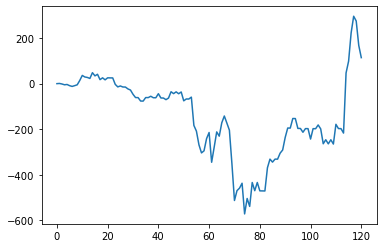

In [27]:
df_random = random_algo(df,'b')

Random algo buys 3948.7377208912217 shares of SH and 2742.944842706915 shares of SDS for a total used cash $ 109000 and total pnl $ 355.5814078094918
Average trade price for SH is $ 18.48198630136987
Average trade price for SDS is $ 13.119722222222224
Sum of Avg_price * inventory for SH+SDS is $ 108967.1908724058


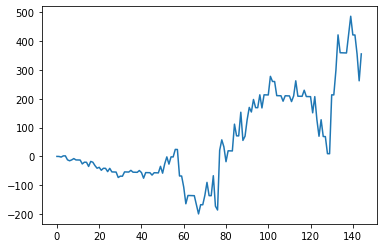

In [28]:
df_random_test=random_algo(df_test,'b')

Weighted_mid algo buys 3171.050261738263 shares of SH and 2215.907141269333 shares of SDS for a total used cash $ 90500 and total pnl $ 121.82715102915245
Average trade price for SH is $ 18.91633333333333
Average trade price for SDS is $ 13.759590163934424
Sum of Avg_price * inventory for SH+SDS is $ 90474.61787299644


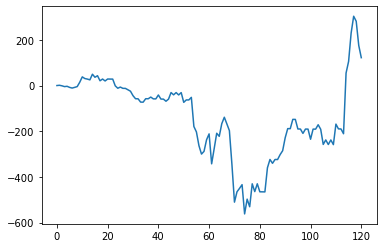

In [29]:
df_weighted=weighted_mid_algo(df,'b')

Weighted_mid algo buys 3893.45383722583 shares of SH and 2783.0338856277745 shares of SDS for a total used cash $ 108500 and total pnl $ 359.4686549829785
Average trade price for SH is $ 18.487638888888892
Average trade price for SDS is $ 13.110342465753424
Sum of Avg_price * inventory for SH+SDS is $ 108467.29590756651


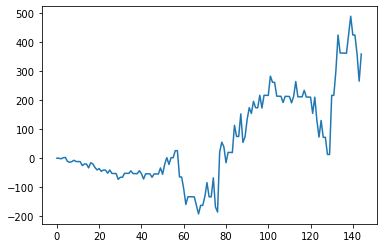

In [30]:
df_weighted_test=weighted_mid_algo(df_test,'b')

Micro algo buys 3169.766547495446 shares of SH and 2217.7308186233718 shares of SDS for a total used cash $ 90500 and total pnl $ 122.64657702440672
Average trade price for SH is $ 18.923999999999996
Average trade price for SDS is $ 13.748278688524588
Sum of Avg_price * inventory for SH+SDS is $ 90474.6434953677


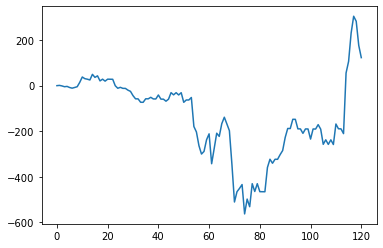

In [31]:
df_micro=micro_algo(df,state_table,'b')

Micro algo buys 5356.865208766105 shares of SH and 1749.8195794540327 shares of SDS for a total used cash $ 122000 and total pnl $ 360.86779958119587
Average trade price for SH is $ 18.476010101010104
Average trade price for SDS is $ 13.139347826086958
Sum of Avg_price * inventory for SH+SDS is $ 121964.9837942559


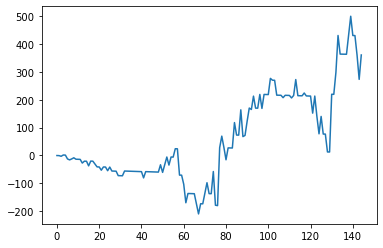

In [32]:
df_micro_test=micro_algo(df_test,state_table,'b')

## Find the states where different executions between weighted-mid algo and micro algo happen

In [33]:
traded_asset=pd.concat([df_random.random_which_asset,df_weighted.weighted_which_asset,df_micro.micro_which_asset,df_micro.current_state],axis=1)
traded_asset

,random_which_asset,weighted_which_asset,micro_which_asset,current_state
time,,,,
2020-11-23 15:40:00+00:00,SH,SDS,SDS,401
2020-11-23 15:45:00+00:00,SDS,SH,SH,111
2020-11-23 15:50:00+00:00,SH,SH,SH,121
2020-11-23 15:55:00+00:00,SH,SH,SH,211
2020-11-23 16:00:00+00:00,SH,SDS,SDS,502
...,...,...,...,...
2020-11-24 01:20:00+00:00,SDS,SDS,SDS,311
2020-11-24 01:25:00+00:00,SDS,SH,SH,221
2020-11-24 01:30:00+00:00,SDS,SDS,SDS,401


In [34]:
traded_asset[traded_asset.weighted_which_asset!=traded_asset.micro_which_asset]

,random_which_asset,weighted_which_asset,micro_which_asset,current_state
time,,,,
2020-11-23 17:10:00+00:00,SDS,SDS,SH,211
2020-11-23 17:20:00+00:00,SH,SDS,SH,211
2020-11-23 17:30:00+00:00,SDS,SDS,SH,211
2020-11-23 18:05:00+00:00,SH,SDS,SH,211
2020-11-23 18:15:00+00:00,SDS,SH,SDS,311
2020-11-23 18:20:00+00:00,SDS,SH,SDS,311
2020-11-23 19:10:00+00:00,SH,SH,SDS,311
2020-11-23 22:10:00+00:00,SH,SH,SDS,311
2020-11-23 22:20:00+00:00,SDS,SH,SDS,311


In [35]:
traded_asset_test=pd.concat([df_random_test.random_which_asset,df_weighted_test.weighted_which_asset,df_micro_test.micro_which_asset,df_micro_test.current_state],axis=1)
traded_asset_test[traded_asset_test.weighted_which_asset!=traded_asset_test.micro_which_asset]

,random_which_asset,weighted_which_asset,micro_which_asset,current_state
time,,,,
2020-12-02 14:45:00+00:00,SH,SDS,SH,012
2020-12-02 14:50:00+00:00,SDS,SDS,SH,011
2020-12-02 15:00:00+00:00,SH,SDS,SH,112
2020-12-02 15:20:00+00:00,SDS,SDS,SH,001
2020-12-02 15:25:00+00:00,SDS,SDS,SH,011
...,...,...,...,...
2020-12-03 02:05:00+00:00,SH,SH,SDS,511
2020-12-03 02:10:00+00:00,SH,SH,SDS,511
2020-12-03 02:30:00+00:00,SDS,SH,SDS,511


In [36]:
traded_asset_test[traded_asset_test.weighted_which_asset!=traded_asset_test.micro_which_asset].current_state.value_counts()

011    20
511    20
012    12
001     9
500     3
000     2
410     1
112     1
101     1
Name: current_state, dtype: int64

C:\Users\Anne Shen\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


American snipper algo (abs diff) buys 3169.766547495446 shares of SH and 2217.7308186233718 shares of SDS for a total used cash $ 90500 and total pnl $ 122.64657702440672
Average trade price for SH is $ 18.923999999999996
Average trade price for SDS is $ 13.748278688524588
Sum of Avg_price * inventory for SH+SDS is $ 90474.6434953677
American snipper algo (abs diff) buys 5356.865208766105 shares of SH and 1749.8195794540327 shares of SDS for a total used cash $ 122000 and total pnl $ 360.86779958119587
Average trade price for SH is $ 18.476010101010104
Average trade price for SDS is $ 13.139347826086958
Sum of Avg_price * inventory for SH+SDS is $ 121964.9837942559
American snipper algo (abs diff) buys 3169.766547495446 shares of SH and 2217.7308186233718 shares of SDS for a total used cash $ 90500 and total pnl $ 122.64657702440672
Average trade price for SH is $ 18.923999999999996
Average trade price for SDS is $ 13.748278688524588
Sum of Avg_price * inventory for SH+SDS is $ 90474.6

American snipper algo (abs diff) buys 3952.598299201113 shares of SH and 2738.271748270108 shares of SDS for a total used cash $ 109000 and total pnl $ 365.5224766340252
Average trade price for SH is $ 18.463904109589038
Average trade price for SDS is $ 13.142083333333334
Sum of Avg_price * inventory for SH+SDS is $ 108966.99148525219
American snipper algo (abs diff) buys 3172.3347914546275 shares of SH and 2214.715465238086 shares of SDS for a total used cash $ 90500 and total pnl $ 129.73531241493765
Average trade price for SH is $ 18.908666666666665
Average trade price for SDS is $ 13.766967213114755
Sum of Avg_price * inventory for SH+SDS is $ 90474.53632299598
American snipper algo (abs diff) buys 3952.598299201113 shares of SH and 2738.271748270108 shares of SDS for a total used cash $ 109000 and total pnl $ 365.5224766340252
Average trade price for SH is $ 18.463904109589038
Average trade price for SDS is $ 13.142083333333334
Sum of Avg_price * inventory for SH+SDS is $ 108966.9

American snipper algo (abs diff) buys 3174.1779032662675 shares of SH and 2176.078024654263 shares of SDS for a total used cash $ 90000 and total pnl $ 132.0359472384589
Average trade price for SH is $ 18.897666666666666
Average trade price for SDS is $ 13.781666666666668
Sum of Avg_price * inventory for SH+SDS is $ 89974.53793306834
American snipper algo (abs diff) buys 3952.598299201113 shares of SH and 2738.301175406165 shares of SDS for a total used cash $ 109000 and total pnl $ 365.91047342293314
Average trade price for SH is $ 18.463904109589038
Average trade price for SDS is $ 13.141944444444444
Sum of Avg_price * inventory for SH+SDS is $ 108966.99789951881
American snipper algo (abs diff) buys 3174.1779032662675 shares of SH and 2176.078024654263 shares of SDS for a total used cash $ 90000 and total pnl $ 132.0359472384589
Average trade price for SH is $ 18.897666666666666
Average trade price for SDS is $ 13.781666666666668
Sum of Avg_price * inventory for SH+SDS is $ 89974.53

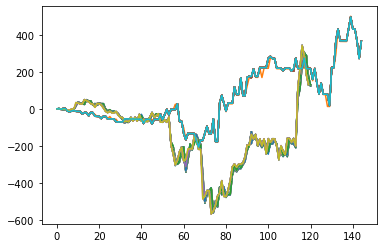

In [37]:
# American Sniper with different thresholds
traded_time_train_buy=[]
traded_time_test_buy=[]
for i in range(30):
    traded_time_train_buy.append(american_sniper_algo_absDiff_constant(df,state_table,i,len(df_micro),buy_or_sell='b'))
    traded_time_test_buy.append(american_sniper_algo_absDiff_constant(df_test,state_table,i,len(df_micro_test),buy_or_sell='b'))

## Sell \\$1000 SH or \\$500 SDS

Random algo sells 3224.297505593684 shares of SH and 2182.3424240018926 shares of SDS for a total used cash $ 91000 and total pnl $ -167.90655833843266
Average trade price for SH is $ 18.924016393442624
Average trade price for SDS is $ 13.752166666666666
Sum of Avg_price * inventory for SH+SDS is $ -91028.5955918024


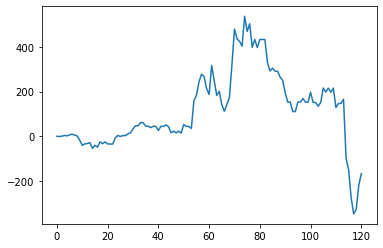

In [38]:
df_random_sell = random_algo(df,'s')

Random algo sells 3950.8748474875592 shares of SH and 2745.0363885110946 shares of SDS for a total used cash $ 109000 and total pnl $ -422.7700807007059
Average trade price for SH is $ 18.48198630136987
Average trade price for SDS is $ 13.119722222222224
Sum of Avg_price * inventory for SH+SDS is $ -109034.12971684948


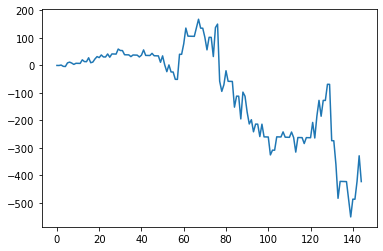

In [39]:
df_random_test_sell = random_algo(df_test,'s')

Weighted_mid algo sells 3222.564342460086 shares of SH and 2184.0919446350304 shares of SDS for a total used cash $ 91000 and total pnl $ -159.1889247002291
Average trade price for SH is $ 18.93418032786885
Average trade price for SDS is $ 13.741166666666665
Sum of Avg_price * inventory for SH+SDS is $ -91028.58580485344


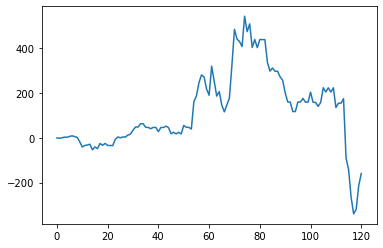

In [40]:
df_weighted_sell = weighted_mid_algo(df,'s')

Weighted_mid algo sells 3950.6396362740165 shares of SH and 2744.835762210365 shares of SDS for a total used cash $ 109000 and total pnl $ -415.765183082578
Average trade price for SH is $ 18.483082191780827
Average trade price for SDS is $ 13.120694444444446
Sum of Avg_price * inventory for SH+SDS is $ -109034.14844350572


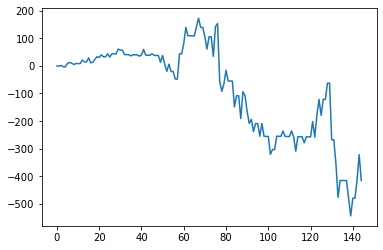

In [41]:
df_weighted_test_sell = weighted_mid_algo(df_test,'s')

Micro algo sells 3223.849414090097 shares of SH and 2182.26561242247 shares of SDS for a total used cash $ 91000 and total pnl $ -158.3586171806419
Average trade price for SH is $ 18.92663934426229
Average trade price for SDS is $ 13.752666666666666
Sum of Avg_price * inventory for SH+SDS is $ -91028.60670646999


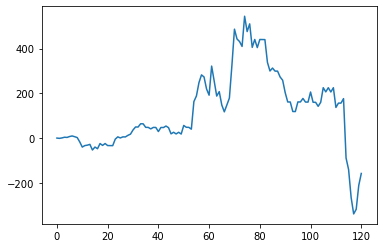

In [42]:
df_micro_sell=micro_algo(df,state_table,'s')

Micro algo sells 2486.434661231354 shares of SH and 3778.8414326339785 shares of SDS for a total used cash $ 95500 and total pnl $ -410.09073520216043
Average trade price for SH is $ 18.505434782608695
Average trade price for SDS is $ 13.104393939393937
Sum of Avg_price * inventory for SH+SDS is $ -95531.98123237398


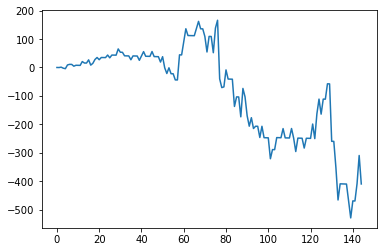

In [43]:
df_micro_test_sell=micro_algo(df_test,state_table,'s')

## Find the states where different executions between weighted-mid algo and micro algo happen

In [44]:
traded_asset_sell=pd.concat([df_random_sell.random_which_asset,df_weighted_sell.weighted_which_asset,df_micro_sell.micro_which_asset,df_micro_sell.current_state],axis=1)
traded_asset_sell[traded_asset_sell.weighted_which_asset!=traded_asset_sell.micro_which_asset]

,random_which_asset,weighted_which_asset,micro_which_asset,current_state
time,,,,
2020-11-23 17:10:00+00:00,SDS,SH,SDS,211
2020-11-23 17:20:00+00:00,SH,SH,SDS,211
2020-11-23 17:30:00+00:00,SDS,SH,SDS,211
2020-11-23 18:05:00+00:00,SH,SH,SDS,211
2020-11-23 18:15:00+00:00,SDS,SDS,SH,311
2020-11-23 18:20:00+00:00,SDS,SDS,SH,311
2020-11-23 19:10:00+00:00,SH,SDS,SH,311
2020-11-23 22:10:00+00:00,SH,SDS,SH,311
2020-11-23 22:20:00+00:00,SDS,SDS,SH,311


In [45]:
traded_asset_test_sell=pd.concat([df_random_test_sell.random_which_asset,df_weighted_test_sell.weighted_which_asset,df_micro_test_sell.micro_which_asset,df_micro_test_sell.current_state],axis=1)
traded_asset_test_sell[traded_asset_test_sell.weighted_which_asset!=traded_asset_test_sell.micro_which_asset]

,random_which_asset,weighted_which_asset,micro_which_asset,current_state
time,,,,
2020-12-02 14:45:00+00:00,SH,SH,SDS,012
2020-12-02 14:50:00+00:00,SDS,SH,SDS,011
2020-12-02 15:00:00+00:00,SH,SH,SDS,112
2020-12-02 15:20:00+00:00,SDS,SH,SDS,001
2020-12-02 15:25:00+00:00,SDS,SH,SDS,011
...,...,...,...,...
2020-12-03 02:05:00+00:00,SH,SDS,SH,511
2020-12-03 02:10:00+00:00,SH,SDS,SH,511
2020-12-03 02:30:00+00:00,SDS,SDS,SH,511


C:\Users\Anne Shen\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


American snipper algo (abs diff) sells 3223.849414090097 shares of SH and 2182.26561242247 shares of SDS for a total used cash $ 91000 and total pnl $ -158.3586171806419
Average trade price for SH is $ 18.92663934426229
Average trade price for SDS is $ 13.752666666666666
Sum of Avg_price * inventory for SH+SDS is $ -91028.60670646999
American snipper algo (abs diff) sells 5354.260385571373 shares of SH and 1757.6684518532716 shares of SDS for a total used cash $ 122000 and total pnl $ -416.07478425081354
Average trade price for SH is $ 18.49500000000001
Average trade price for SDS is $ 13.090652173913043
Sum of Avg_price * inventory for SH+SDS is $ -122036.07217141401
American snipper algo (abs diff) sells 3223.849414090097 shares of SH and 2182.26561242247 shares of SDS for a total used cash $ 91000 and total pnl $ -158.3586171806419
Average trade price for SH is $ 18.92663934426229
Average trade price for SDS is $ 13.752666666666666
Sum of Avg_price * inventory for SH+SDS is $ -91028

American snipper algo (abs diff) sells 3891.4614430907022 shares of SH and 2789.609514302171 shares of SDS for a total used cash $ 108500 and total pnl $ -409.2392937603072
Average trade price for SH is $ 18.50708333333334
Average trade price for SDS is $ 13.089383561643835
Sum of Avg_price * inventory for SH+SDS is $ -108533.87013564532
American snipper algo (abs diff) sells 3221.2801078201833 shares of SH and 2185.2805813698014 shares of SDS for a total used cash $ 91000 and total pnl $ -151.24445683608428
Average trade price for SH is $ 18.941721311475405
Average trade price for SDS is $ 13.733666666666666
Sum of Avg_price * inventory for SH+SDS is $ -91028.50514620174
American snipper algo (abs diff) sells 3891.4614430907022 shares of SH and 2789.609514302171 shares of SDS for a total used cash $ 108500 and total pnl $ -409.2392937603072
Average trade price for SH is $ 18.50708333333334
Average trade price for SDS is $ 13.089383561643835
Sum of Avg_price * inventory for SH+SDS is $

American snipper algo (abs diff) sells 3166.6949701589538 shares of SH and 2187.7153753493567 shares of SDS for a total used cash $ 90000 and total pnl $ -150.6926588522656
Average trade price for SH is $ 18.95233333333333
Average trade price for SDS is $ 13.718333333333332
Sum of Avg_price * inventory for SH+SDS is $ -90028.06739694346
American snipper algo (abs diff) sells 3891.4614430907022 shares of SH and 2789.5807964948335 shares of SDS for a total used cash $ 108500 and total pnl $ -408.86064947056
Average trade price for SH is $ 18.50708333333334
Average trade price for SDS is $ 13.089520547945206
Sum of Avg_price * inventory for SH+SDS is $ -108533.87637160573
American snipper algo (abs diff) sells 3166.6949701589538 shares of SH and 2187.7153753493567 shares of SDS for a total used cash $ 90000 and total pnl $ -150.6926588522656
Average trade price for SH is $ 18.95233333333333
Average trade price for SDS is $ 13.718333333333332
Sum of Avg_price * inventory for SH+SDS is $ -9

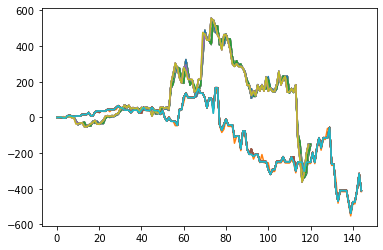

In [46]:
# American Sniper with different thresholds
traded_time_train_sell=[]
traded_time_test_sell=[]
for i in range(30):
    traded_time_train_sell.append(american_sniper_algo_absDiff_constant(df,state_table,i,len(df_micro),buy_or_sell='s'))
    traded_time_test_sell.append(american_sniper_algo_absDiff_constant(df_test,state_table,i,len(df_micro_test),buy_or_sell='s'))

# Results

In [47]:
result_table=pd.DataFrame(results,columns=['buy_or_sell','algo','P_SH','Q_SH','P_SDS','Q_SDS','PNL'])
result_table['train_or_test']=['train','test']*(len(result_table)//2)
result_table

,buy_or_sell,algo,P_SH,Q_SH,P_SDS,Q_SDS,PNL,train_or_test
0,b,1. random algo,18.924016,3222.594113,13.752167,2180.755984,113.766719,train
1,b,1. random algo,18.481986,3948.737721,13.119722,2742.944843,355.581408,test
2,b,2. weighted mid algo,18.916333,3171.050262,13.759590,2215.907141,121.827151,train
3,b,2. weighted mid algo,18.487639,3893.453837,13.110342,2783.033886,359.468655,test
4,b,3. micro algo,18.924000,3169.766547,13.748279,2217.730819,122.646577,train
...,...,...,...,...,...,...,...,...
127,s,4. American sniper algo_27,18.507083,-3891.461443,13.089521,-2789.580796,-408.860649,test
128,s,4. American sniper algo_28,18.956333,-3166.025125,13.712167,-2188.695249,-151.510005,train
129,s,4. American sniper algo_28,18.507083,-3891.461443,13.089110,-2789.668139,-410.012264,test
130,s,4. American sniper algo_29,18.956333,-3166.025125,13.712167,-2188.695249,-151.510005,train


In [48]:
multi=result_table.set_index(['buy_or_sell', 'algo','train_or_test'])
multi

P_SH         Q_SH  \
buy_or_sell algo                       train_or_test                           
b           1. random algo             train          18.924016  3222.594113   
                                       test           18.481986  3948.737721   
            2. weighted mid algo       train          18.916333  3171.050262   
                                       test           18.487639  3893.453837   
            3. micro algo              train          18.924000  3169.766547   
...                                                         ...          ...   
s           4. American sniper algo_27 test           18.507083 -3891.461443   
            4. American sniper algo_28 train          18.956333 -3166.025125   
                                       test           18.507083 -3891.461443   
            4. American sniper algo_29 train          18.956333 -3166.025125   
                                       test           18.507083 -3891.461443   

                                                          P_SDS        Q_SDS  \
buy_or_sell algo                       train_or_test                           
b           1. random algo             train          13.752167  2180.755984   
                                       test           13.119722  2742.944843   
            2. weighted mid algo       train          13.759590  2215.907141   
                                       test           13.110342  2783.033886   
            3. micro algo              train          13.748279  2217.730819   
...                                                         ...          ...   
s           4. American sniper algo_27 test           13.089521 -2789.580796   
            4. American sniper algo_28 train          13.712167 -2188.695249   
                                       test           13.089110 -2789.668139   
            4. American sniper algo_29 train          13.712167 -2188.695249   
                                       test           13.089110 -2789.668139   

                                                             PNL  
buy_or_sell algo                       train_or_test              
b           1. random algo             train          113.766719  
                                       test           355.581408  
            2. weighted mid algo       train          121.827151  
                                       test           359.468655  
            3. micro algo              train          122.646577  
...                                                          ...  
s           4. American sniper algo_27 test          -408.860649  
            4. American sniper algo_28 train         -151.510005  
                                       test          -410.012264  
            4. American sniper algo_29 train         -151.510005  
                                       test          -410.012264  

[132 rows x 5 columns]

In [49]:
pd.options.display.float_format = '{:,.3f}'.format
multi.groupby(level=[2,1])[['Q_SH','Q_SDS','PNL']].sum()

Q_SH      Q_SDS     PNL
train_or_test algo                                                   
test          1. random algo                -2.137     -2.092 -67.189
              2. weighted mid algo         -57.186     38.198 -56.297
              3. micro algo              2,870.431 -2,029.022 -49.223
              4. American sniper algo_00     2.605     -7.849 -55.207
              4. American sniper algo_01    61.137    -51.338 -43.717
...                                            ...        ...     ...
train         4. American sniper algo_25     7.483    -11.637 -18.657
              4. American sniper algo_26     7.483    -11.637 -18.657
              4. American sniper algo_27     7.483    -11.637 -18.657
              4. American sniper algo_28     8.823    -13.595 -20.246
              4. American sniper algo_29     8.823    -13.595 -20.246

[66 rows x 3 columns]

In [50]:
x=multi.groupby(level=[2,1])[['Q_SH','Q_SDS','PNL']].sum()
# x.to_csv('Results_Nov23Dec2.csv')

# PNL comparison for train and test using different constraints

In [51]:
y=result_table.set_index(['train_or_test','algo','buy_or_sell'])
z=y.groupby(level=[0,1])[['Q_SH','Q_SDS','PNL']].sum()

In [52]:
z.loc['train']

,Q_SH,Q_SDS,PNL
algo,,,
1. random algo,-1.703,-1.586,-54.140
2. weighted mid algo,-51.514,31.815,-37.362
3. micro algo,-54.083,35.465,-35.712
4. American sniper algo_00,-54.083,35.465,-35.712
4. American sniper algo_01,-54.083,35.465,-35.712
4. American sniper algo_02,-54.083,35.465,-35.712
4. American sniper algo_03,-54.083,35.465,-35.712
4. American sniper algo_04,-54.083,35.465,-35.712
4. American sniper algo_05,-54.083,35.465,-35.712


In [53]:
z.loc['test']

,Q_SH,Q_SDS,PNL
algo,,,
1. random algo,-2.137,-2.092,-67.189
2. weighted mid algo,-57.186,38.198,-56.297
3. micro algo,"2,870.431","-2,029.022",-49.223
4. American sniper algo_00,2.605,-7.849,-55.207
4. American sniper algo_01,61.137,-51.338,-43.717
4. American sniper algo_02,61.137,-51.338,-43.717
4. American sniper algo_03,61.137,-51.338,-43.717
4. American sniper algo_04,61.137,-51.338,-43.717
4. American sniper algo_05,61.137,-51.338,-43.717


In [54]:
###################################### depends on the constant threshold ##################################################
result=pd.concat([z.loc['train'].iloc[:3],z.loc['train'].iloc[[23]],z.loc['test'].iloc[:3],z.loc['test'].iloc[[23]]])
result['train_or_test']=['train']*4+['test']*4
result

,Q_SH,Q_SDS,PNL,train_or_test
algo,,,,
1. random algo,-1.703,-1.586,-54.140,train
2. weighted mid algo,-51.514,31.815,-37.362,train
3. micro algo,-54.083,35.465,-35.712,train
4. American sniper algo_20,-50.174,31.233,-19.993,train
1. random algo,-2.137,-2.092,-67.189,test
2. weighted mid algo,-57.186,38.198,-56.297,test
3. micro algo,"2,870.431","-2,029.022",-49.223,test
4. American sniper algo_20,61.137,-51.338,-43.717,test


In [55]:
result.to_csv('Results_Nov23Dec2.csv')

# Execution time (early execution proportion)

In [56]:
algo_names=z.loc['train'].index[3:]

# executing time of every period if we cut the period to 30 buckets
df_traded_time_train_buy=pd.DataFrame(map(list, zip(*traded_time_train_buy)),columns=algo_names)
df_traded_time_train_buy

algo,4. American sniper algo_00,4. American sniper algo_01,4. American sniper algo_02,4. American sniper algo_03,4. American sniper algo_04,4. American sniper algo_05,4. American sniper algo_06,4. American sniper algo_07,4. American sniper algo_08,4. American sniper algo_09,...,4. American sniper algo_20,4. American sniper algo_21,4. American sniper algo_22,4. American sniper algo_23,4. American sniper algo_24,4. American sniper algo_25,4. American sniper algo_26,4. American sniper algo_27,4. American sniper algo_28,4. American sniper algo_29
0,early,early,early,early,early,early,early,early,early,early,...,early,early,early,early,early,early,early,early,early,early
1,early,early,early,early,early,early,early,early,early,early,...,early,early,early,early,early,early,early,early,end_of_5_min,end_of_5_min
2,early,early,early,early,early,early,early,early,early,early,...,early,early,early,early,early,early,early,early,early,early
3,early,early,early,early,early,early,early,early,early,early,...,early,early,early,early,early,early,early,early,early,early
4,early,early,early,early,early,early,early,early,early,early,...,early,early,early,early,early,early,early,early,early,early
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,early,early,early,early,early,early,early,early,early,early,...,early,early,early,early,early,early,early,early,early,early
116,early,early,early,early,early,early,early,early,early,early,...,early,early,early,early,early,early,early,early,early,early
117,early,early,early,early,early,early,early,early,early,early,...,early,early,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min
118,early,early,early,early,early,early,early,early,early,early,...,early,early,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min,end_of_5_min


In [57]:
df_traded_time_train_sell=pd.DataFrame(map(list, zip(*traded_time_train_sell)),columns=algo_names)
df_traded_time_test_buy=pd.DataFrame(map(list, zip(*traded_time_test_buy)),columns=algo_names)
df_traded_time_test_sell=pd.DataFrame(map(list, zip(*traded_time_test_sell)),columns=algo_names)

In [58]:
# Execution time in each period
execute_time_train_buy=df_traded_time_train_buy.apply(pd.value_counts).fillna(0).astype('int32')
execute_time_train_buy

algo,4. American sniper algo_00,4. American sniper algo_01,4. American sniper algo_02,4. American sniper algo_03,4. American sniper algo_04,4. American sniper algo_05,4. American sniper algo_06,4. American sniper algo_07,4. American sniper algo_08,4. American sniper algo_09,...,4. American sniper algo_20,4. American sniper algo_21,4. American sniper algo_22,4. American sniper algo_23,4. American sniper algo_24,4. American sniper algo_25,4. American sniper algo_26,4. American sniper algo_27,4. American sniper algo_28,4. American sniper algo_29
early,120,120,120,120,120,120,116,110,110,110,...,110,106,80,80,80,80,80,80,76,76
end_of_5_min,0,0,0,0,0,0,4,10,10,10,...,10,14,40,40,40,40,40,40,44,44


In [59]:
# proportion of executing early (not at the end of 5 minutes)
execute_time_train_buy.loc['early']/len(df_traded_time_train_buy)*100

algo
4. American sniper algo_00   100.000
4. American sniper algo_01   100.000
4. American sniper algo_02   100.000
4. American sniper algo_03   100.000
4. American sniper algo_04   100.000
4. American sniper algo_05   100.000
4. American sniper algo_06    96.667
4. American sniper algo_07    91.667
4. American sniper algo_08    91.667
4. American sniper algo_09    91.667
4. American sniper algo_10    91.667
4. American sniper algo_11    91.667
4. American sniper algo_12    91.667
4. American sniper algo_13    91.667
4. American sniper algo_14    91.667
4. American sniper algo_15    91.667
4. American sniper algo_16    91.667
4. American sniper algo_17    91.667
4. American sniper algo_18    91.667
4. American sniper algo_19    91.667
4. American sniper algo_20    91.667
4. American sniper algo_21    88.333
4. American sniper algo_22    66.667
4. American sniper algo_23    66.667
4. American sniper algo_24    66.667
4. American sniper algo_25    66.667
4. American sniper algo_26    66.

In [60]:
# proportion of executing early (not at the end of 5 minutes)
execute_time_train_sell=df_traded_time_train_sell.apply(pd.value_counts).fillna(0).astype('int32')
execute_time_train_sell.loc['early']/len(df_traded_time_train_sell)*100

algo
4. American sniper algo_00   100.000
4. American sniper algo_01   100.000
4. American sniper algo_02   100.000
4. American sniper algo_03   100.000
4. American sniper algo_04   100.000
4. American sniper algo_05   100.000
4. American sniper algo_06    96.667
4. American sniper algo_07    91.667
4. American sniper algo_08    91.667
4. American sniper algo_09    91.667
4. American sniper algo_10    91.667
4. American sniper algo_11    91.667
4. American sniper algo_12    91.667
4. American sniper algo_13    91.667
4. American sniper algo_14    91.667
4. American sniper algo_15    91.667
4. American sniper algo_16    91.667
4. American sniper algo_17    91.667
4. American sniper algo_18    91.667
4. American sniper algo_19    91.667
4. American sniper algo_20    91.667
4. American sniper algo_21    88.333
4. American sniper algo_22    66.667
4. American sniper algo_23    66.667
4. American sniper algo_24    66.667
4. American sniper algo_25    66.667
4. American sniper algo_26    66.

In [61]:
# proportion of executing early (not at the end of 5 minutes)
execute_time_test_buy=df_traded_time_test_buy.apply(pd.value_counts).fillna(0).astype('int32')
execute_time_test_buy.loc['early']/len(df_traded_time_test_buy)*100

algo
4. American sniper algo_00   100.000
4. American sniper algo_01   100.000
4. American sniper algo_02   100.000
4. American sniper algo_03   100.000
4. American sniper algo_04   100.000
4. American sniper algo_05   100.000
4. American sniper algo_06   100.000
4. American sniper algo_07   100.000
4. American sniper algo_08   100.000
4. American sniper algo_09   100.000
4. American sniper algo_10   100.000
4. American sniper algo_11   100.000
4. American sniper algo_12   100.000
4. American sniper algo_13   100.000
4. American sniper algo_14   100.000
4. American sniper algo_15   100.000
4. American sniper algo_16   100.000
4. American sniper algo_17   100.000
4. American sniper algo_18   100.000
4. American sniper algo_19   100.000
4. American sniper algo_20   100.000
4. American sniper algo_21   100.000
4. American sniper algo_22   100.000
4. American sniper algo_23   100.000
4. American sniper algo_24   100.000
4. American sniper algo_25   100.000
4. American sniper algo_26   100.

In [62]:
# proportion of executing early (not at the end of 5 minutes)
execute_time_test_sell=df_traded_time_test_sell.apply(pd.value_counts).fillna(0).astype('int32')
execute_time_test_sell.loc['early']/len(df_traded_time_test_sell)*100

algo
4. American sniper algo_00   100.000
4. American sniper algo_01   100.000
4. American sniper algo_02   100.000
4. American sniper algo_03   100.000
4. American sniper algo_04   100.000
4. American sniper algo_05   100.000
4. American sniper algo_06   100.000
4. American sniper algo_07   100.000
4. American sniper algo_08   100.000
4. American sniper algo_09   100.000
4. American sniper algo_10   100.000
4. American sniper algo_11   100.000
4. American sniper algo_12   100.000
4. American sniper algo_13   100.000
4. American sniper algo_14   100.000
4. American sniper algo_15   100.000
4. American sniper algo_16   100.000
4. American sniper algo_17   100.000
4. American sniper algo_18   100.000
4. American sniper algo_19   100.000
4. American sniper algo_20   100.000
4. American sniper algo_21   100.000
4. American sniper algo_22   100.000
4. American sniper algo_23   100.000
4. American sniper algo_24   100.000
4. American sniper algo_25   100.000
4. American sniper algo_26   100.